In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt

from tqdm import tqdm

from scipy.optimize import minimize, root_scalar

from matplotlib.colors import LogNorm, Normalize

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

from matplotlib import cm

In [2]:
sigmoid = lambda x: 1. / (1 + np.exp(-beta * x))
log_sigmoid = lambda x: -np.logaddexp(0, -beta * x)


def generate_extraction_graph(N, T, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    G = []
    for t in range(T):
        i = np.random.randint(N)
        while True:
            j = np.random.randint(N)
            if i != j: break
        G.append([i, j, t])
    return np.array(G)


def generate_dynamics(N, T, G, mu=0.5, eps=.25, beta=50, x0=None, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    if x0 is None:
        x0 = np.random.uniform(size=N) * 2 - 1
    
    u_v_t_w = []
    
    t = 0
    X = [x0]
    for i, j, t in G:
        if t >= T:
            break
        xt = X[-1]
        xtp1 = xt.copy()
        dist = np.abs(xt[i] - xt[j])
        p = sigmoid(eps-dist)
        extraction = np.random.uniform()
        if extraction<=p:
            xtp1[i] += mu * (xt[j] - xt[i])
            xtp1[j] += mu * (xt[i] - xt[j])
            u_v_t_w.append( (i, j, t, 1) )
        else:
            u_v_t_w.append( (i, j, t, 0) )
        xtp1 = np.clip(xtp1, -1, 1)
    
        X.append(xtp1)
    X = np.vstack(X)
    
    return u_v_t_w, X


def neg_log_likelihood(params):
    eps_hat, mu_hat = params
    xt = x0.copy()
    # X = [xt]
    log_likelihood = 0
    for i, j, t, has_interacted_at_t in u_v_t_w:
        dist = np.abs(xt[i] - xt[j])
        if has_interacted_at_t:
            log_sigma = log_sigmoid(eps_hat - dist)  # to avoid overflow
            log_likelihood += log_sigma
            xt[i] += mu_hat * (xt[j] - xt[i])
            xt[j] += mu_hat * (xt[i] - xt[j])
        else:
            log_likelihood -= np.logaddexp(0, beta*(eps_hat - dist))
        # X.append(xt.copy())
    return -log_likelihood

In [3]:
def min_max(v):
    return (np.min(v), np.max(v))

# A special case: $\mu=0.01, \varepsilon=0.75$

In [4]:
mu = 0.01
eps = 0.75
seed = 7

beta = 60
N = 100

In [5]:
T = 10000

initial_seed = 0

results = []
ll_profile = []

# for T in [100., 600, 1200., 2300.,  3400.,  4500.,  5600., 6700.,  7800., 8900., 10000.]: 
G = generate_extraction_graph(N, int(T), seed=seed)

np.random.seed(seed)
x0 = np.random.uniform(size=int(N)) * 2 - 1

trial = 0
trial_seed = np.random.randint(low=0, high=32000)
u_v_t_w, X = generate_dynamics(N, T, G, mu=mu, eps=eps, beta=beta, x0=x0, seed=trial_seed)
u_v_t_w = np.array(u_v_t_w)

initial_guess = np.random.uniform(low=0.1, high=.5, size=2)
nll_minimum = minimize(neg_log_likelihood, 
                   x0=initial_guess,
                   bounds=[(0., 2.), (0., 0.5)], 
                   method='Nelder-Mead'
                  )

for mu_hat in tqdm(np.linspace(0., .5, 51)):
    for eps_hat in np.linspace(0., 1., 101):
        nll = neg_log_likelihood((eps_hat, mu_hat))
        ll_profile.append([N, T, seed, eps_hat, mu_hat, nll])

print(N, T, seed, neg_log_likelihood((eps, mu)), neg_log_likelihood(nll_minimum.x), nll_minimum.x)

results.append([N, T, seed, trial, trial_seed, nll_minimum.x[0], nll_minimum.x[1]])


results = np.array(results)
df = pd.DataFrame(results, columns=['N', 'T', 'seed', 'trial', 'trial_seed', 'eps_hat', 'mu_hat'])

ll_profile = np.array(ll_profile)
ll_df = pd.DataFrame(ll_profile, columns=['N', 'T', 'seed', 'eps', 'mu', 'nll'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [04:08<00:00,  4.88s/it]

100 10000 7 320.20184508107627 12820.127110853304 [0.05118233 0.49713455]


In [6]:
ll_df_pivot = ll_df.pivot(index='eps', columns='mu', values='nll').copy()

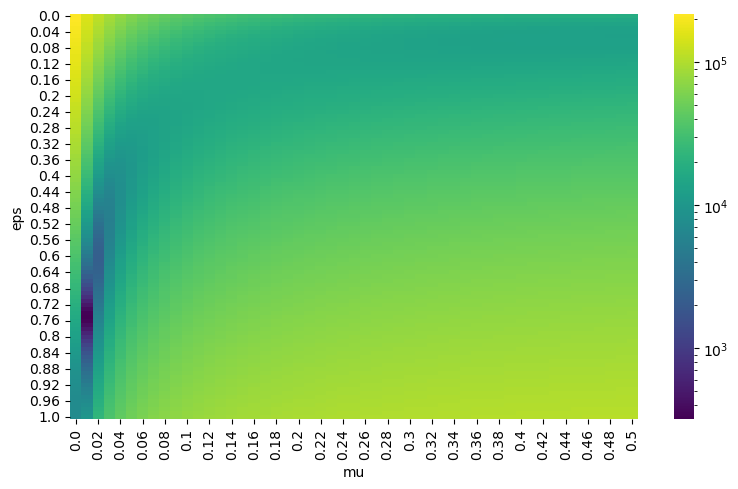

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))
sb.heatmap(ll_df_pivot, norm=LogNorm(), cmap='viridis', ax=ax)
plt.tight_layout()

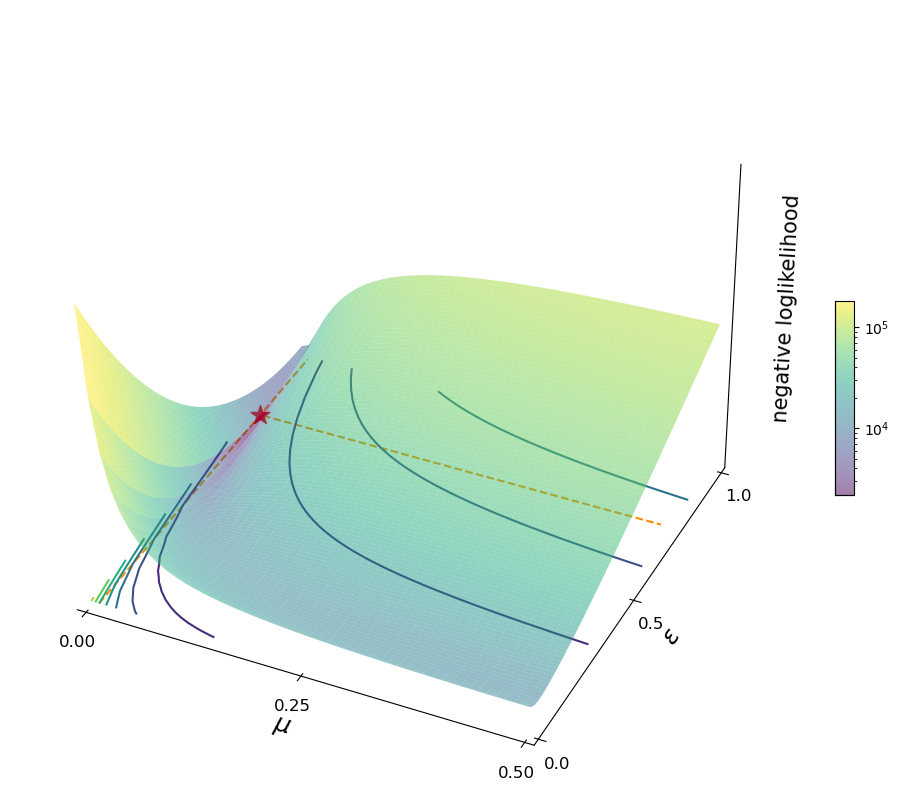

In [8]:
Y, X = np.meshgrid(ll_df_pivot.index, ll_df_pivot.columns)

Z = ll_df_pivot.to_numpy()

X = X.T
Y = Y.T

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')


surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.5, cmap=cm.viridis, norm=LogNorm())
cset = ax.contour(X, Y, Z, zdir='z', offset=np.min(Z), cmap=cm.viridis)
fig.colorbar(surf, ax=ax, shrink=0.2, aspect=10)

# ax.view_init(azim=-55)
ax.view_init(35, azim=-65)
ax.set_xlabel(r'$\mu$', fontsize=18)
ax.set_xlim(0, .5)
ax.set_ylabel(r'$\varepsilon$', fontsize=18)
ax.set_ylim(0, 1.)
ax.set_zlabel('negative loglikelihood', fontsize=15)
ax.set_zlim(np.min(Z), np.max(Z))
ax.set_xticks([0., 0.25, .5])
ax.set_yticks([0., 0.5, 1.])
ax.set_zticks([])
ax.tick_params(axis='both', which='major', labelsize=12)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.grid(False)

# ax.set_zscale('log')
imin, jmin = np.unravel_index(ll_df_pivot.to_numpy().argmin(), ll_df_pivot.shape)
ax.plot3D([mu]*len(np.arange(0., 1., 0.01)), np.arange(0., 1., 0.01),  ax.get_zlim()[0], c='darkorange', ls='--')
ax.plot3D(np.arange(0., 0.5, 0.01), [eps]*len(np.arange(0., 0.5, 0.01)),  ax.get_zlim()[0], c='darkorange', ls='--')
ax.scatter3D([ll_df_pivot.columns[jmin]], [ll_df_pivot.index[imin]], ax.get_zlim()[0], marker='*', s=200, c='r')

sb.despine()
plt.tight_layout()
fig.savefig(f'../figs/likelihood_profile_{eps}_{mu}_{beta}_{N}_{T}_{initial_seed}.pdf')

# $\mu=0.3, \varepsilon=0.5$

In [4]:
mu = 0.3
eps = 0.5
beta = 15
N = 1000
T = 10000
initial_seed = 0

In [5]:
old_df = pd.read_csv(f"../outputs/{mu}_{eps}_{beta}_{N}_{T}_df.csv", index_col=0)

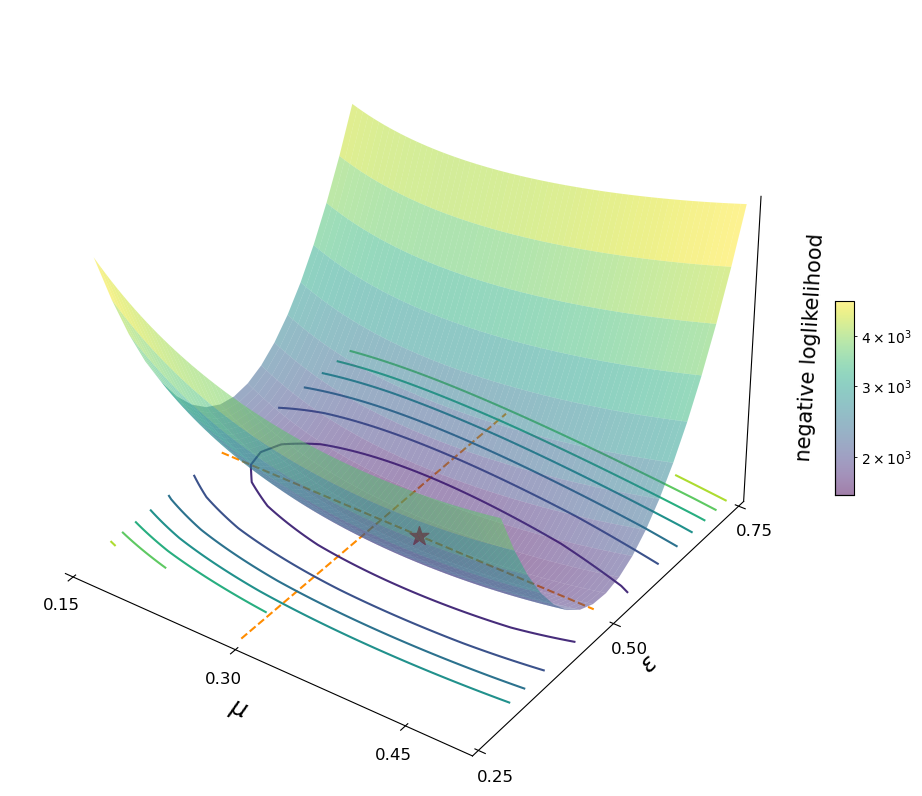

In [18]:
A = old_df.groupby(['eps_hat', 'mu_hat'])['nll'].mean().unstack(1)
A = A.iloc[12:31, 30:101].copy()
Y, X = np.meshgrid(A.index, A.columns)

Z = A.to_numpy()

X = X.T
Y = Y.T

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')


surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.5, cmap=cm.viridis, norm=LogNorm())
# surf = ax.plot_surface(X, Y, Z, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                # alpha=0.3)

cset = ax.contour(X, Y, Z, zdir='z', offset=np.min(Z), cmap=cm.viridis)
# cset = ax.contour(X, Y, Z, zdir='x', offset=0, cmap=cm.coolwarm)
# cset = ax.contour(X, Y, Z, zdir='y', offset=1., cmap=cm.coolwarm)


cbar = fig.colorbar(surf, ax=ax, shrink=0.2, aspect=10)

ax.view_init(35, azim=-55)
ax.set_xlabel(r'$\mu$', fontsize=18)
ax.set_xlim(0.15, .5)
ax.set_ylabel(r'$\varepsilon$', fontsize=18)
ax.set_ylim(0.25, .7)
ax.set_zlabel('negative loglikelihood', fontsize=15)
ax.set_zlim(np.min(Z), np.max(Z))
ax.set_xticks([0.15, 0.30, .45])
ax.set_yticks([0.25, 0.5, .75])
ax.set_zticks([])
ax.tick_params(axis='both', which='major', labelsize=12)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.grid(False)



# ax.set_title('3D surface with 2D contour plot projections')

# ax.set_zscale('log')
imin, jmin = np.unravel_index(A.to_numpy().argmin(), A.shape)
ax.plot3D([mu]*len(np.arange(0.25, 0.75, 0.01)), np.arange(0.25, 0.75, 0.01),  ax.get_zlim()[0], c='darkorange', ls='--')
ax.plot3D(np.arange(0.15, 0.5, 0.01), [eps]*len(np.arange(0.15, 0.5, 0.01)),  ax.get_zlim()[0], c='darkorange', ls='--')
ax.scatter3D([A.columns[jmin]], [A.index[imin]], ax.get_zlim()[0], marker='*', s=200, c='r')
sb.despine()
plt.tight_layout()

fig.savefig(f'../figs/likelihood_profile_{eps}_{mu}_{beta}_{N}_{T}_{initial_seed}.pdf')